In [1]:
from itertools import product

import zarr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from distributed import Client
from numcodecs import blosc
from skimage.restoration import denoise_tv_chambolle
from skimage.exposure import rescale_intensity

In [2]:
client = Client()

In [3]:
codec = blosc.Blosc(cname="zstd", clevel=9, shuffle=blosc.Blosc.SHUFFLE)

In [4]:
image_path = "/root/capsule/data/exaSPIM_706301_training_blocks/block_001/block_001.zarr"
arr = da.from_zarr(image_path, component='0').squeeze()
slice_num = arr.shape[0] // 2
side = 50
# float64 is at least an order of magnitude slower to denoise
s = arr[slice_num-side:slice_num+side, ...].compute().astype(np.float32)
print(s.shape)

(100, 1024, 1024)


In [5]:
minimum, maximum = s.min(), s.max()
print(minimum, maximum)

0.0 277.0


In [6]:
def plot_slice(s, title=None, vmin=0, vmax=65535):
    plt.figure(figsize=(8,8))
    plt.imshow(s, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

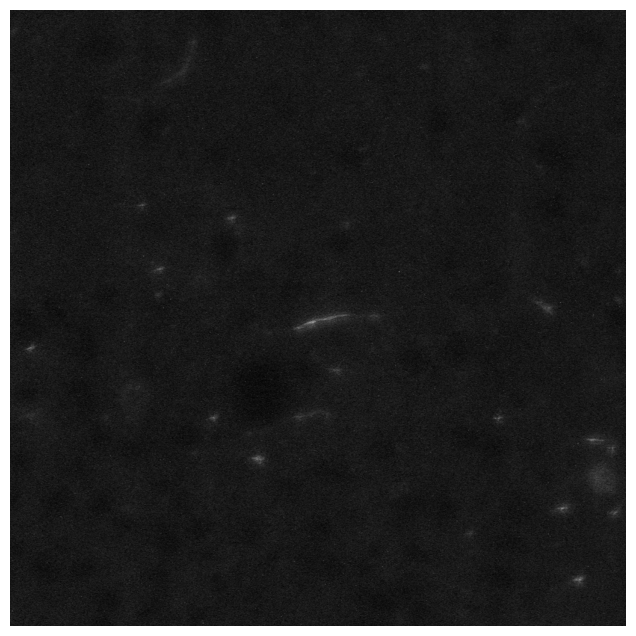

In [7]:
plot_slice(s[50], vmin=minimum, vmax=maximum)

In [8]:
weights = [i for i in range(1, 17, 2)]
max_iterations = [200]

params = list(product(weights, max_iterations))
#print(params)

Compression ratio: 3.380693355260519


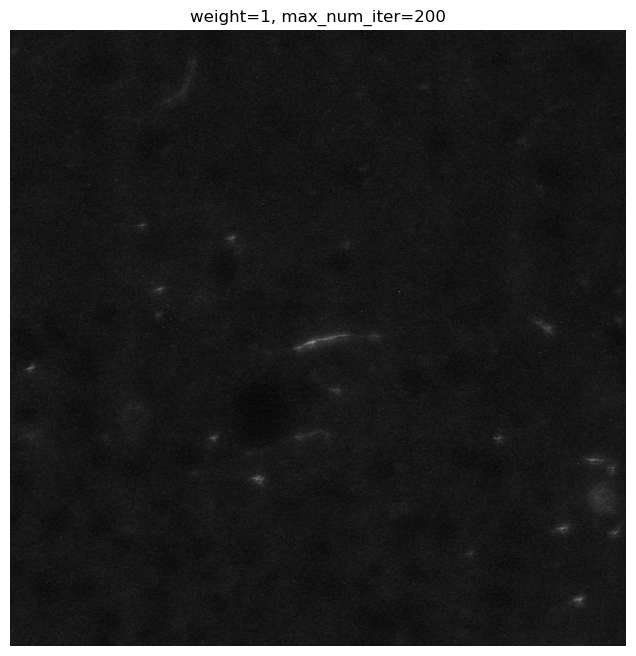

Compression ratio: 4.864747325429585


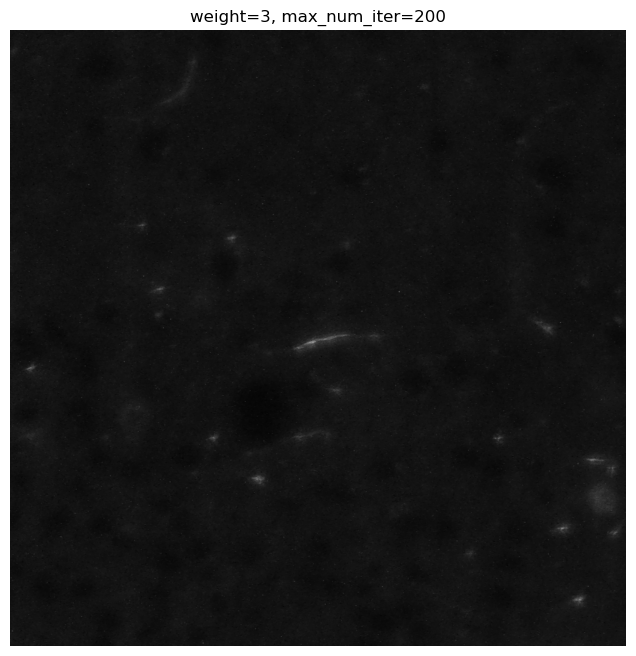

Compression ratio: 9.69550507446852


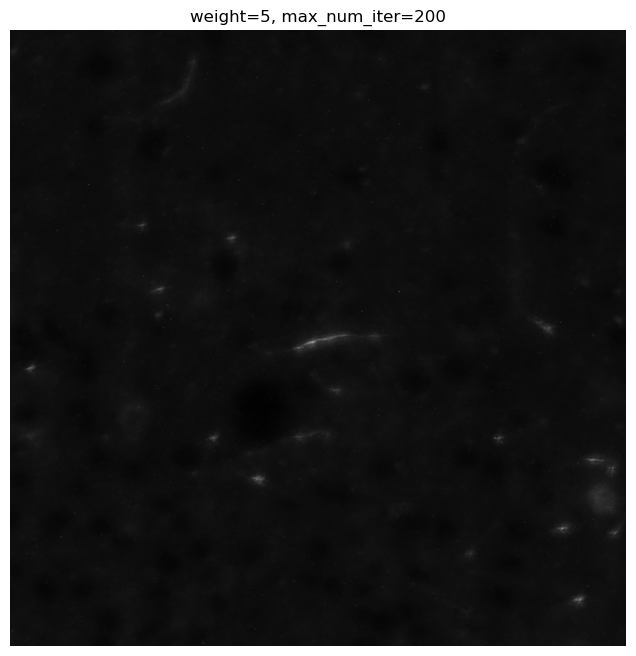

Compression ratio: 11.56631715609453


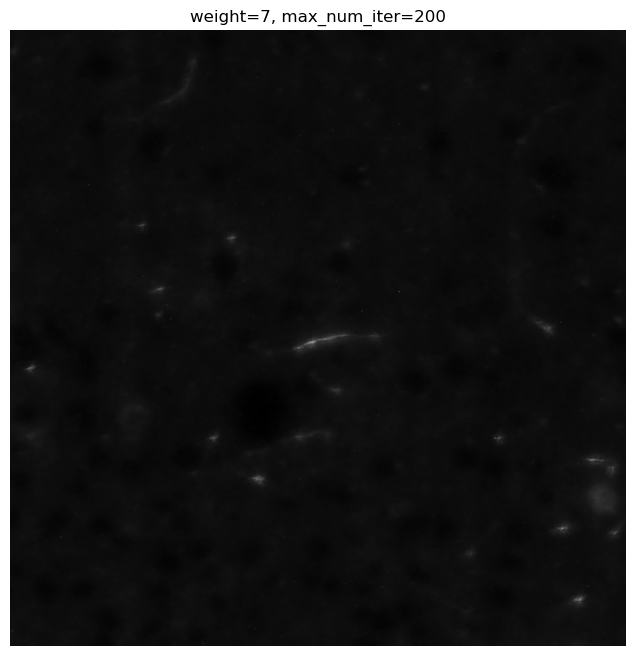

Compression ratio: 10.428412594878871


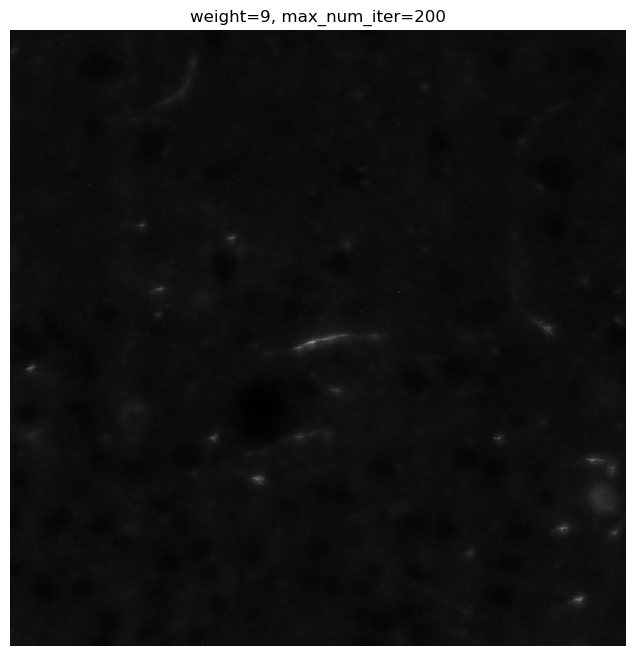

Compression ratio: 13.113294403574061


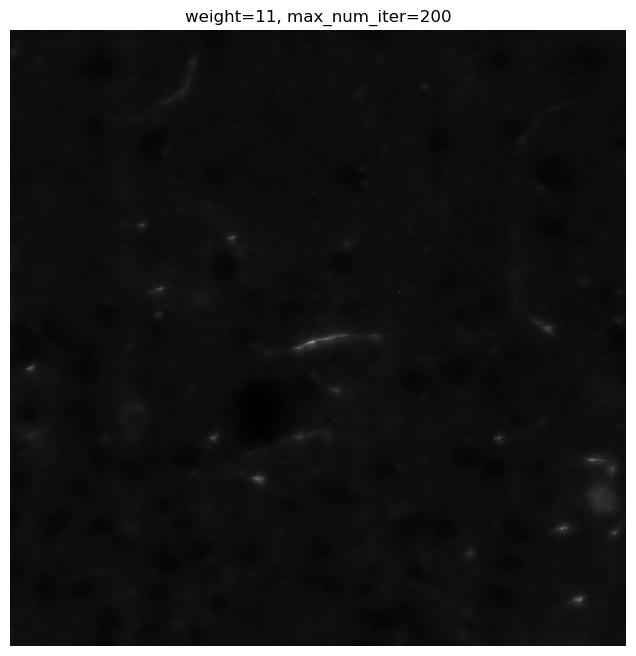

Compression ratio: 14.501282617050474


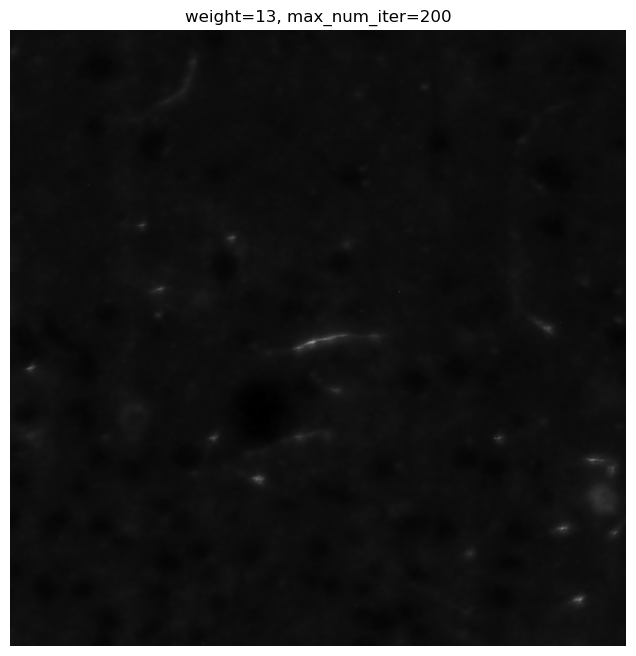

Compression ratio: 15.599897942257039


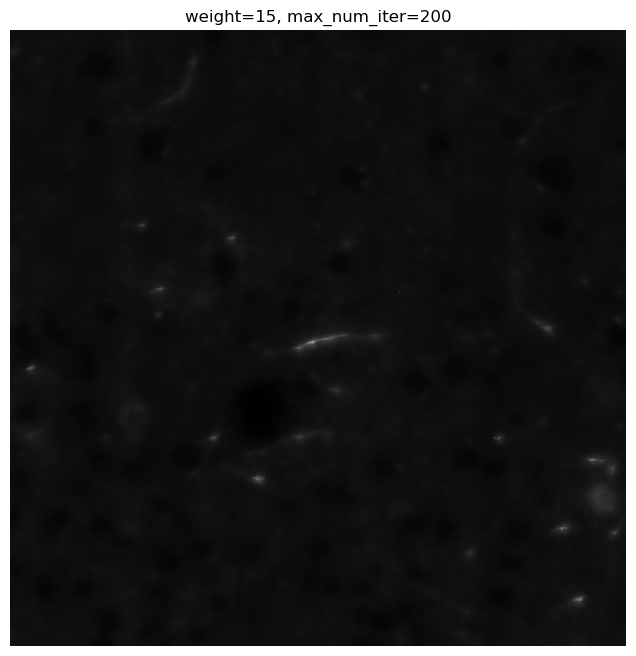

In [9]:
for param_set in params:
    w, max_iter = param_set
    
    result = denoise_tv_chambolle(
        s, 
        weight=w,
        max_num_iter=max_iter,
        channel_axis=None
    )
    result = rescale_intensity(result, in_range="image", out_range=(minimum, maximum)).astype(np.uint16)  
    
    encoded_bytes = len(codec.encode(result))
    print(f"Compression ratio: {s.astype(np.uint16).nbytes / encoded_bytes}")
    
    plot_slice(result[50], title=f"weight={w}, max_num_iter={max_iter}", vmin=minimum, vmax=maximum)